# Predicting Housing Prices, Model Selection
## Overview

The dataset is a Housing Prices dataset found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) 

We will build a regression model to predict housing prices and submit to the competition.

## Baseline Model

In [ ]:
!pip install -U scikit-learn
!pip install -U statsmodels
!pip show scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)
Name: scikit-learn
Version: 0.24.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: joblib, threadpoolctl, numpy, scipy
Required-by: yellowbrick, textgenrnn, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn, fancyimpute


In [ ]:
# Mount so that we can access files on Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the data
import pandas as pd

workdir = "/content/drive/My Drive/Colab Notebooks/housing-prices/"
train_filepath = workdir + "train.csv"
test_filepath = workdir + "test.csv"

raw_data = pd.read_csv(train_filepath, index_col="Id")
X_test = pd.read_csv(test_filepath, index_col="Id")

target_col = 'SalePrice'
X = raw_data.drop(target_col, axis=1)
y = raw_data[target_col]

In [ ]:
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

numerical_transformer = Pipeline(
    steps=[('num_impute', SimpleImputer(strategy='mean')),
           ('standardize', StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
           ('ord_encoding', OneHotEncoder(handle_unknown="ignore"))]
)

# Using a subset of the features because using all 79 features will cause an explosion in MSE
baseline_num_cols = ['YearBuilt', 'OverallQual', 'OverallCond', 'LotArea', '1stFlrSF', 
                     '2ndFlrSF', 'BedroomAbvGr', 'WoodDeckSF', 'OpenPorchSF']
baseline_cat_cols = ['LotFrontage', 'KitchenQual', 'Heating', 'RoofStyle', 'RoofMatl',
                     'BldgType', 'Neighborhood']

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, baseline_num_cols),
                  ('cat', categorical_transformer, baseline_cat_cols)]
)

model = LinearRegression()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])

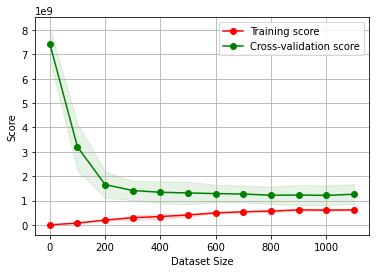

Train score - size   1 - mean   0.000000 - scores                                             [0. 0. 0. 0. 0.]
Train score - size 101 - mean 77904081.246537 - scores [75892218.06283794 78407047.04246159 78407047.04246159 78407047.04246159
 78407047.04246159]
Train score - size 201 - mean 196675798.059901 - scores [2.53008662e+08 1.82592582e+08 1.82592582e+08 1.82592582e+08
 1.82592582e+08]
Train score - size 301 - mean 296766459.928973 - scores [4.83198011e+08 2.61245135e+08 2.46463051e+08 2.46463051e+08
 2.46463051e+08]
Train score - size 401 - mean 343854198.312451 - scores [5.56290505e+08 3.26301325e+08 2.78893054e+08 2.78893054e+08
 2.78893054e+08]
Train score - size 501 - mean 407754320.073171 - scores [5.41954429e+08 3.75227397e+08 3.73863258e+08 3.73863258e+08
 3.73863258e+08]
Train score - size 601 - mean 493515588.588719 - scores [5.34784205e+08 4.31166456e+08 4.88932462e+08 5.06347410e+08
 5.06347410e+08]
Train score - size 701 - mean 539454995.680070 - scores [5.97900568e+08

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes, 
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    return train_scores, test_scores

def pretty_learning_curve(clf, X, y, scoring, train_sizes):
  
  plt.xlabel("Dataset Size")
  plt.ylabel("Score")
  train_scores, valid_scores = plot_learning_curve(clf, "Learning Curve", X, y, 
                                                   train_sizes=train_sizes, scoring=scoring)
  plt.show()

  for train_size, scores in zip(train_sizes, train_scores):
    print("Train score - size %3d - mean %10f - scores %60s" % 
          (train_size, np.mean(scores), str(scores)))

  print()

  for train_size, scores in zip(train_sizes, valid_scores):
    print("Valid score - size %3d - mean %10f - scores %60s" % 
          (train_size, np.mean(scores), str(scores)))

X_baseline = X[baseline_num_cols + baseline_cat_cols]
y_baseline = y

train_sizes = [100 * i + 1 for i in range(0, 12)]
pretty_learning_curve(pipe, X_baseline, y_baseline, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=train_sizes)

In [ ]:
global_random_state=0
global_valid_size=0.3

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error

def score_classifier(pipe, X, y, cv_num=10, n_repeats=5):
  cv_strategy = RepeatedKFold(n_splits=cv_num, n_repeats=n_repeats, 
                              random_state=global_random_state)
  scoring_strategy = make_scorer(mean_squared_error)
  score = cross_val_score(pipe, X, y, cv=cv_strategy, 
                          n_jobs=-1, scoring=scoring_strategy)
  return np.mean(score), score

class Evaluator():
  def fit(self, pipe, X, y):
    self.baseline = score_classifier(pipe, X, y)[0]
    return self

  def evaluate(self, pipe, X, y):
    return score_classifier(pipe, X, y)[0] - self.baseline

  def get_baseline(self):
    return self.baseline

evaluator = Evaluator()
evaluator.fit(pipe, X_baseline, y_baseline)

print("The baseline cross-validation score is: %f" % 
      evaluator.get_baseline()) 

The baseline cross-validation score is: 1248912305.301590


## Preprocessing

Based on the results of the EDA, we must perform the following steps for all models

- **[ENG]** - Construct the initial model using `GrLivArea`, `OverallQual`,`GarageArea`, `1stFlrSF`, `YearBuilt` all as predictors.
- **[ENG]** - Change `MSSubClass` into a categorical feature. 
- **[ENG]** - Replace "NA" with "Absent" for some of the features.

- **[ENG]** - Discard `GarageYrBlt`. There is no reasonable imputation value and it is correlated with `YearBuilt`, so the information is redundant.
- **[ENG]** - Impute `LotFrontage` to 0, median, or mean. 
- **[ENG]** - Impute `Electrical` to be the most frequent value.
- **[ENG]** - Try: (1) impute MasVnrArea using the median/mean and MasVnrType with the most frequent observation, (2) first impute MasVnrType with the most frequent observation, then impute MasVnrArea with the average MasVnrArea for the most frequent MasVnrType.
- **[ENG]** - Drop the record where `Stone` has 0 `MasVnrArea` (id 1242). This might be erroneous record.

We will perform the following steps primarily for linear regression. Although, we may experiment with using these steps for other models. 

- **[ENG]** - Fit to the logarithm of `SalePrice` to satisfy linearity.
- **[ENG]** - Discard `GarageYrBlt`
- **[ENG]** - Discard `TotRmsAbvGrd`
- **[ENG]** - Discard `TotalBsmtSF`
- **[ENG]** - Discard `GarageCars`
- **[ENG]** - Discard `2ndFlrSF`

We can try the following additional steps on the models, especially linear regression, to see if it improves performance. 

- **[ENG]** - Drop `SalePrice` outliers to see if that improves model performance.
- **[ENG]** - Try discarding `BsmtFullBath`
- **[ENG]** - Try discarding `TotRmsAbvGrd` and keeping the individual above-grade room counts. Compare this to just keeping `TotRmsAbvGrd `to determine if there is any performance boost.
- **[ENG]** - Try discarding `GrLivArea` or `1stFlrSF` or keeping both to see if there is any performance boost.
- **[ENG]** - Try discarding `HalfBath`. If we are preprocessing in an alternate way, where we discard `2ndFlrSF`, then try to keep `HalfBath`
- **[ENG]** - Try discarding either `BsmtUnfSF` or `BsmtFinSF1` or keeping both.
- **[ENG]** - Try discarding `BedroomAbvGr` over `GrLivArea`
- **[ENG]** - Consider dropping `FullBath` and `OverallQual`, which are correlated with `GrLivArea`. Note that `FullBath` is correlated with `OverallQual`
- **[ENG]** - Run experiments using `FullBath`, `YearRemodAdd` as features
- **[ENG]** - Run experiments using `MasVnrArea`, `Fireplaces`, `BsmtFinSF1`, `LotFrontage`, `2ndFlrSF`, `OpenPorchSF`, `WoodDeckSF` as features.
- **[ENG]** - Run experiments using features with absolute correlation $<=0.30$ as predictors.

If additional boosts in performance are necessary, then we might consider adding the categorical features. These features are somewhat undesirable  for linear regression, because they are not continuous features which would "play" better with the model. These might be useful in other models, however. 

- **[ENG]** - Empirically check if discarding `Neighborhood` or `MSZoning` improves performance
- **[ENG]** - Discard `BsmtCond` or `BsmtQual`, depending on which has less correlation with `SalePrice`
- **[ENG]** - Try discarding `BsmtExposure`, `BsmtFinType1`, and `BsmtFinType2`, as they are nominal variables, whereas `BsmtQual` and `BsmtCond` are continuous variables that capture some of the information. 
- **[ENG]** - Empirically check if discarding `GarageFinish` and/or `GarageType` in favour of `GarageQual` leads to performance boosts.
- **[ENG]** - Try manipulating the basement and garage categorical variables to remove redundancy and improve performance. Create a preprocessor that empirically checks every non-empty subset of the collinear features, then tests to see which one yields the best performance. 

Some additional suggestions for experiments:

- **[ENG]** - Try computing the number of years in-between YearBuilt and YearSold as a feature.

In [ ]:
# Correcting columns that use 'NA' to denote a certain category of information
cols_with_NA_category = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                         'BsmtFinType2', 'BsmtQual', 'Fence', 'FireplaceQu', 
                         'GarageCond', 'GarageFinish', 'GarageQual', 
                         'GarageType', 'MiscFeature', 'PoolQC']
NA_category = 'Absent'

# Replace 'NA' with "Absent" to ensure the category is interpreted properly
X['MSSubClass'] = X['MSSubClass'].astype('object')
X[cols_with_NA_category] = X[cols_with_NA_category].fillna(NA_category)
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Absent,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Absent,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,Absent,Absent,Absent,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Absent,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,Absent,Absent,Absent,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,Absent,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,Absent,Absent,Absent,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,Absent,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,Absent,Absent,Absent,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,Absent,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,Absent,Absent,Absent,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,Absent,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,Absent,Absent,Absent,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,Absent,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,Absent,MnPrv,Absent,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,Absent,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,Absent,GdPrv,Shed,2500,5,2010,WD,Normal


In [ ]:
# Compute the numerical and object columns
mask = X.dtypes == 'object'
object_cols = list(mask[mask].index)
numerical_cols = list(set(X.columns) - set(object_cols))

In [ ]:
ordinal_cols = ['LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 
                'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 
                'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
                'PoolQC', 'Fence', 'MiscFeature']

nominal_cols = list(set(object_cols) - set(ordinal_cols))

## Utilities

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

class FeatureSelection(BaseEstimator, TransformerMixin):
  ''' Add this to a pipeline to ensure that only a `subset` of the features
      is being used. Avoids having to pollute the global namespace with
      modified copies of `X` with names like `X1`, `X2`, `X3`. Instead, just
      pass in `X`, `y` without touching the features and let this transformer
      handle the rest.
  '''

  def __init__(self, subset):
    self.subset = subset

  def fit(self, X, y):
    return self

  def transform(self, X, y = None):
    return X[self.subset]


def transform(y):
  return np.log(y)

def inverse_transform(y):
  return np.exp(y)

def evaluate(evaluator, make_pipeline, prev_best_score):
  cur_score = evaluator.evaluate(make_pipeline(), X, y)
  print("The difference in performance is: %f" % cur_score)
  print("Change since last best score: %f" % (cur_score - prev_best_score))
  return cur_score

def fit_best_features(make_pipeline, grid, evaluator, base_score):
  best_score = None
  best_feats = None 
  for key, cols in grid.items():
    pipe = make_pipeline(cols)
    score = evaluator.evaluate(pipe, X, y)

    if best_score is None or score < best_score:
      best_score = score
      best_feats = key

    print(key)
    print("The difference in performance is: %f" % score)
    print("Change since last best score: %f" % (score - base_score))
    print()

  print("The best performance increase is: %f" % best_score)
  print("The features that created this increase is: %s" % best_feats)

  return best_score, best_feats

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=global_valid_size, random_state=global_random_state
)

## Linear Regression

### Simple Model
We begin by using only the most correlated features and seeing the result.

In [ ]:
# Begin with the predictors that have the highest correlation with `SalePrice`
predictors1 = ['GrLivArea', 'OverallQual', 'GarageArea', '1stFlrSF', 'YearBuilt']

def make_pipeline1():
  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors1)),
                         ('scale', StandardScaler()),
                         ('model', LinearRegression())])

In [ ]:
pretty_learning_curve(make_pipeline1(), X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=train_sizes)

In [ ]:
score1 = evaluator.evaluate(make_pipeline1(), X, y)
print("The difference in performance is: %f" % score1)

The number `282424869.901296` is interpreted as `current_score - baseline_score`

We can see that with only 5 features, the linear regression model performs considerably worse than the baseline. Let consider adding additional predictors to see if that improves, performance. We prioritize adding the columns with highest correlation with `SalePrice`, but with no multicollinearity when paired with the existing columns in `predictors1` 

### With Multicollinearity
Let us use `GarageCars` to observe what happens when we add a column that has multicollineariy (and thus, would violate one of linear regression's assumptions).  

In [ ]:
predictors2 = predictors1 + ['GarageCars']

def make_pipeline2():
  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors2)),
                         ('scale', StandardScaler()),
                         ('model', LinearRegression())])

In [ ]:
pretty_learning_curve(make_pipeline2(), X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=train_sizes)

In [ ]:
score2 = evaluator.evaluate(make_pipeline2(), X, y)
print("The difference in performance is: %f" % score2)
print("Change since last best score: %f" % (score2 - score1))

Observe how the resulting performance for `pipe2` is worse than `pipe1`. This might be explained by the fact that `GarageCars` is highly correlated with `GarageArea`, as shown by EDA.

We instead add `LotFrontage`, which is only mildly correlated with features like `GarageArea`.

In [ ]:
predictors3 = predictors1 + ['LotFrontage']
# predictors3 = predictors1 + ['OpenPorchSF'] # similarly does not improve performance

def make_pipeline3():
  numerical_imputer = SimpleImputer(strategy='mean')

  imputer = ColumnTransformer(
      transformers=[
        ('num', numerical_imputer, predictors3)
      ]
  )

  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors3)),
                         ('imputer', imputer),
                         ('scale', StandardScaler()),
                         ('model', LinearRegression())])

In [ ]:
pretty_learning_curve(make_pipeline3(), X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=train_sizes)

In [ ]:
score3 = evaluator.evaluate(make_pipeline3(), X, y)
print("The difference in performance is: %f" % score3)
print("Change since last best score: %f" % (score3 - score1))

The resulting model has an even worse performance than the model which included `GarageCars`. The `LotFrontage` does not have any strong correlations with any other feature in `predictors1`. This suggests that the magnitude of correlation is somewhat unreliable as way to perform feature selection.

Let us start with all of the features and see if removing features will improve performance, instead.

### All Numeric Features

Here we add numeric features in an attempt to make the regression model achieve higher performance. 

In [ ]:
def make_pipeline4():
  predictors = numerical_cols

  numerical_imputer = SimpleImputer(strategy='mean')

  imputer = ColumnTransformer(
      transformers=[
        ('num', numerical_imputer, numerical_cols)
      ]
  )

  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                          ('imputer', imputer),
                          ('scale', StandardScaler()),
                          ('model', LinearRegression())])
  
pipe4 = make_pipeline4()

In [ ]:
pretty_learning_curve(make_pipeline4(), X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=[600, 700, 800, 900, 1000]) # Valid score spikes for size 200-500

In [ ]:
score4 = evaluator.evaluate(pipe4, X, y)
print("The difference in performance is: %f" % score4)
print("Change since last best score: %f" % (score4 - score1))

By adding all of the numeric features, the linear regression model's performance is now better than the first model that was used. It seems that simply adding more information can improve model performance, so we can try again with the ordinal features. 

### Adding Ordinal Features

Here we add ordinal features to the model to improve model performance. 

In [ ]:
def get_trimmed(to_filter):
  return list(set(ordinal_cols) - set(to_filter))

def get_extended(to_add):
  return ['LandSlope', 'ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageFinish'] + to_add

# Uncomment to see the other results 
ordinal_cols_subsets = {
    # 'landSlope' : ['LandSlope'],
    # 'exterQual' : ['ExterQual'],
    # 'exterCond' : ['ExterCond'],
    # 'bsmtQual' : ['BsmtQual'],
    # 'bsmtCond' : ['BsmtCond'],
    # 'bsmtExposure' : ['BsmtExposure'],
    # 'bsmtFinType1' : ['BsmtFinType1'],
    # 'bsmtFinType2' : ['BsmtFinType2'],
    # 'heatingQC' : ['HeatingQC'],
    # 'kitchenQual' : ['KitchenQual'],
    # 'functional' : ['Functional'],
    # 'fireplaceQu' : ['FireplaceQu'],
    # 'garageFinish' : ['GarageFinish'],
    # 'garageQual' : ['GarageQual'],
    # 'garageCond' : ['GarageCond'],
    # 'pavedDrive' : ['PavedDrive'],
    # 'poolQC' : ['PoolQC'],
    # 'fence' : ['Fence'],
    # 'miscFeature' : ['MiscFeature'],
    # 'improve1' : ['LandSlope', 'ExterQual'],
    # 'improve2' : ['LandSlope', 'ExterQual', 'BsmtQual'],
    # 'improve3' : ['LandSlope', 'ExterQual', 'BsmtQual', 'KitchenQual'],
    # 'improve4' : ['LandSlope', 'ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu'],
    # 'improve5' : ['LandSlope', 'ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageFinish'],
    # 'degrade1' : get_extended(['ExterCond']),
    # 'degrade2' : get_extended(['BsmtCond']),
    # 'degrade3' : get_extended(['BsmtExposure']),
    # 'degrade4' : get_extended(['BsmtFinType1']),
    # 'degrade5' : get_extended(['BsmtFinType2']),
    # 'degrade6' : get_extended(['HeatingQC']),
    # 'degrade7' : get_extended(['Functional']),
    # 'degrade8' : get_extended(['GarageQual']),
    # 'degrade9' : get_extended(['GarageCond']),
    # 'degrade11' : get_extended(['PoolQC']),
    # 'degrade12' : get_extended(['Fence']),
    # 'degrade13' : get_extended(['MiscFeature']),
    'degrade10' : get_extended(['PavedDrive']),
    'extend1' : get_extended(['PavedDrive', 'ExterCond']),
    'extend2' : get_extended(['PavedDrive', 'BsmtCond']),
    'extend3' : get_extended(['PavedDrive', 'BsmtExposure']),
    'extend4' : get_extended(['PavedDrive', 'BsmtFinType1']),
    'extend5' : get_extended(['PavedDrive', 'BsmtFinType2']),
    'extend6' : get_extended(['PavedDrive', 'HeatingQC']),
    'extend7' : get_extended(['PavedDrive', 'Functional']),
    'extend8' : get_extended(['PavedDrive', 'GarageQual']),
    'extend9' : get_extended(['PavedDrive', 'GarageCond']),
    'extend11' : get_extended(['PavedDrive', 'PoolQC']),
    'extend12' : get_extended(['PavedDrive', 'Fence']),
    'extend13' : get_extended(['PavedDrive', 'MiscFeature']),
    # 'all' : get_trimmed([]),
    # 'trim_1' : get_trimmed(['FireplaceQu']),
    # 'trim_2' : get_trimmed(['PoolQC']),
    # 'trim_3' : get_trimmed(['MiscFeature']),
    # 'trim_4' : get_trimmed(['Fence']),
    # 'trim_5' : get_trimmed(['Fence', 'FireplaceQu', 'PoolQC', 'MiscFeature']),
}

def make_pipeline5(numerical_cols, ordinal_cols):

  predictors = numerical_cols + ordinal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
      ])

  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', LinearRegression())])

def make_pipeline5_with_ord(ord_cols):
    return make_pipeline5(numerical_cols, ord_cols)

In [ ]:
best_score5, best_ord_feats5 = fit_best_features(make_pipeline5_with_ord,
                                               ordinal_cols_subsets,
                                               evaluator, score4)

The following is observed:
- `OverallQual`, `Fence`, `FireplaceQu`, `PoolQC`, `MiscFeatures` - These features appear to be useless or actively detrimental to the linear regression model if they are the sole feature being added. In particular, `OverallQual` pushes the MSE of the linear regression to infinity when it is added, so we are forced to discard this feature. 
- `ExterQual`, `GarageQual` - Leads to a performance increase. 

One hypothesis for why some features cause performance degradation is that the linear regression model does not behave well when the categorical variable is 90-99% of one category. The intuition is that such features wouldn't be informative anyways, because all but one category have insufficient data points and you cannot generalize from a small sample size reliably. 

The following features, when added to the numerical columns, leads to a performance increase:
- `LandSlope` - Skewed class 
- `ExterQual` - Two comparable classes
- `BsmtQual` - Two comparable classes
- `KitchenQual` - Two comparable classes 
- `FireplaceQu` - Three comparable classes 
- `GarageFinish` - Three comparable classes 

The following features, when added to the categorical columns, leads to performance degradation.
- `ExterCond` - Extremely detrimental - Skewed class
- `BsmtCond` - Skewed class 
- `BsmtExposure` - Skewed class
- `BsmtFinType1` - At least two comparable classes 
- `BsmtFinType2` - Skewed class
- `HeatingQC` - Extremely detrimental
- `Functional` - Extremely detrimental - Skewed class
- `GarageQual` - Extremely detrimental - Skewed class
- `GarageCond`  - Extremely detrimental - Skewed class 
- `PavedDrive` - Skewed class 
- `PoolQC` - Extremely detrimental - Skewed class
- `Fence` - Skewed class
- `MiscFeature` - Skewed class

This scheme is not perfect and there are counter-examples. For example, `LandSlope` is dominated by one category, but still provides a performance increase. Note, however, that the increase is relatively small compared to the other features: `-163187.196632`. On the other hand, `BsmtFinType1` is not dominated by one category.

In [ ]:
pretty_learning_curve(make_pipeline5_with_ord(ordinal_cols_subsets[best_ord_feats5]), 
                      X, y, scoring=make_scorer(mean_squared_error), 
                      train_sizes=[600, 700, 800, 900, 1000]) # Valid score spikes for size 200-500

### Adding Nominal Features

Here we add nominal features to improve model performance. 

In [ ]:
# Uncomment to see all outputs
nominal_cols_subsets = {
    'baseline' : [],
    'all' : nominal_cols,
    # 'Neighborhood' : ['Neighborhood'],
    # 'Condition1' : ['Condition1'],
    # 'GarageType' : ['GarageType'],
    # 'HouseStyle' : ['HouseStyle'],
    # 'Condition2' : ['Condition2'],
    # 'Exterior1st' : ['Exterior1st'],
    # 'BldgType' : ['BldgType'],
    # 'CentralAir' : ['CentralAir'],
    # 'Street' : ['Street'],
    # 'MSSubClass' : ['MSSubClass'],
    # 'Alley' : ['Alley'],
    # 'MasVnrType' : ['MasVnrType'],
    # 'Foundation' : ['Foundation'],
    # 'MSZoning' : ['MSZoning'],
    # 'LotConfig' : ['LotConfig'],
    # 'Heating' : ['Heating'],
    # 'SaleType' : ['SaleType'],
    # 'RoofStyle' : ['RoofStyle'],
    # 'RoofMatl' : ['RoofMatl'],
    # 'LandContour' : ['LandContour'],
    # 'LotShape' : ['LotShape'],
    # 'Exterior2nd' : ['Exterior2nd'],
    # 'SaleCondition' : ['SaleCondition'],
    # 'Utilities' : ['Utilities'],
    # 'Electrical' : ['Electrical'],
    'cherry-pick' : ['Condition1', 'HouseStyle', 'BldgType', 'Street',
                     'MSSubClass', 'Alley', 'MasVnrType', 'MSZoning',
                     'LotConfig', 'LandContour'],
    'highest-decrease' : ['HouseStyle', 'BldgType', 'MSSubClass', 'MSZoning'],
    'cherry-pick-2' : ['HouseStyle', 'MSZoning'],
}

def make_pipeline6(numerical_cols, ordinal_cols, nominal_cols):

  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])

  return Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', LinearRegression())])

def make_pipeline6_with_nom(nominal_cols):
    return make_pipeline6(numerical_cols, ordinal_cols_subsets[best_ord_feats5],
                          nominal_cols)

In [ ]:
score6, best_nom_feats6 = fit_best_features(make_pipeline6_with_nom,
                                            nominal_cols_subsets,
                                            evaluator, best_score5)

In [ ]:
pretty_learning_curve(make_pipeline6_with_nom(nominal_cols_subsets[best_nom_feats6]), 
                      X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=[400, 500, 600, 700, 800, 900, 1000, 1100])

### Transforming the Target

In [ ]:
def make_pipeline7(numerical_cols, ordinal_cols, nominal_cols):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', LinearRegression())])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

pipe7 = make_pipeline7(numerical_cols,
                       ordinal_cols_subsets[best_ord_feats5],
                       nominal_cols_subsets[best_nom_feats6])

In [ ]:
score7 = evaluator.evaluate(pipe7, X, y)
print("The difference in performance is: %f" % score7)
print("Change since last best score: %f" % (score7 - score6))

By applying a logarithm onto the target feature, we able to fit all of the features onto the `LinearRegression` model. Although this does not lead to a performance improvement in the cross-validation score, it opens the possibility to fit all of the features, whereas before the score became too large to measure. 

## Linear Regression II

It may be more effective to transform the target, then attempt to fit the linear regression model on all of the features. This would allow us to see how removing or adding features affects the model score, while accounting for all of the interactions between features, whether they are good or bad. 

### All Features (Again)

In [ ]:
def make_pipeline1a(numerical_cols, ordinal_cols, nominal_cols):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', LinearRegression())])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

In [ ]:
pretty_learning_curve(make_pipeline1a(numerical_cols, ordinal_cols, nominal_cols), 
                      X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=[100 * i for i in range(5, 12)])

In [ ]:
score1a = evaluate(evaluator, 
                   lambda: make_pipeline1a(numerical_cols,
                                           ordinal_cols,
                                           nominal_cols), 
                   score6)

While the performance appears to be worse than `score6`, the best score we obtained from our first attempt to fit linear regression, one thing to observe is that the best training score for our first attempt is: `448352332.715567`. 
In contrast, the training score here is `283302039.440293`.

We could try tuning hyperparameters to see if we can narrow the gap between training and cross-validation for our current model, then it might beat our previous best. 

### Ridge Regression

We will attempt to put an L2 regularization term to the `LinearRegression` model using `RidgeRegression`. Ideally, this will minimize overfitting and allow us to beat our previously best scoring model. Even more ideal is if this technique allows us to beat the baseline. 

In [ ]:
from sklearn.linear_model import Ridge

def make_pipeline2a(numerical_cols, ordinal_cols, nominal_cols, alpha=1.0):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', Ridge(alpha=alpha))])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

In [ ]:
alphas = [1, 10, 100, 1000, 10000, 11000, 15000, 18000, 20000, 30000]
scores = []

score2a = None
best_alpha = None
for alpha in alphas:
  print("Alpha = %f" % alpha)
  score = evaluate(evaluator, 
                   lambda: make_pipeline2a(numerical_cols,
                                           ordinal_cols,
                                           nominal_cols,
                                           alpha), 
                   score6)
  
  scores.append(score)

  if score2a is None or score < score2a:
    score2a = score
    best_alpha = alpha

plt.plot(alphas, scores)
plt.title("Hyperparameter Tuning of Alpha")
plt.xlabel("Alpha")
plt.ylabel("Mean cross-validation score")
plt.tight_layout()

print("The best score is: %f" % score2a)
print("The alpha setting is: %f" % best_alpha)

In [ ]:
pretty_learning_curve(make_pipeline2a(numerical_cols, ordinal_cols, nominal_cols, best_alpha), 
                      X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=[100 * i for i in range(5, 12)])

Unfortunately, ridge regression can only push down the cross-validation score to be `1607489203.257070` higher than our previous best score. As the learning curve above shows, we have already reduced overfitting to nearly the minimum possible degree.  

The model appears to be severely underfitting, as both the training and validation score are significantly worse than the previous linear regression model we used. 

In [ ]:
from sklearn.linear_model import Lasso

def make_pipeline3a(numerical_cols, ordinal_cols, nominal_cols, alpha=1.0):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', Lasso(alpha=alpha))])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

### Lasso Regression

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
scores = []

score3a = None
best_lasso_alpha = None
for alpha in alphas:
  print("Alpha = %f" % alpha)
  score = evaluate(evaluator, 
                   lambda: make_pipeline3a(numerical_cols,
                                           ordinal_cols,
                                           nominal_cols,
                                           alpha), 
                   score6)
  
  scores.append(score)

  if score3a is None or score < score3a:
    score3a = score
    best_lasso_alpha = alpha

plt.plot(alphas, scores)
plt.title("Hyperparameter Tuning of Alpha")
plt.xlabel("Alpha")
plt.ylabel("Mean cross-validation score")
plt.tight_layout()

print("The best score is: %f" % score3a)
print("The alpha setting is: %f" % best_lasso_alpha)

In [ ]:
pretty_learning_curve(make_pipeline3a(numerical_cols, ordinal_cols, nominal_cols, best_lasso_alpha), 
                      X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=[100 * i for i in range(1, 12)])

Lasso Regression appears to work better than Ridge Regression, since the training error is lower. The problem, however, is that the training error is still one order of magnitude higher than the training score achieved by the simple linear regression model incorporating all features.

This model is significantly underfitting, we will attempt to use a more complex model like Random Forests or neural nets.

### Rank Encoding

### Discarding Highly Correlated Features

### Discarding Features Experiments

## Random Forest Regressor

### Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def make_pipeline1b(numerical_cols, ordinal_cols, nominal_cols,
                    max_depth=10, n_estimators=200,
                    min_samples_split=5, min_samples_leaf=2):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])
  
  model = RandomForestRegressor(criterion="mse", verbose=1, n_jobs=-1,
                                max_depth=max_depth)

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', model)])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

In [ ]:
pretty_learning_curve(make_pipeline1b(numerical_cols, ordinal_cols, nominal_cols), 
                      X, y, 
                      scoring=make_scorer(mean_squared_error), 
                      train_sizes=train_sizes)

In [ ]:
score1b = evaluate(evaluator, 
                   lambda: make_pipeline1b(numerical_cols,
                                           ordinal_cols,
                                           nominal_cols), 
                   score6)

According to the learning curve, there appears to be some overfitting. However, the cross-validation score is far lower than the baseline linear regression model. 

Hence, the random forest regressor is a good starting point to obtain more accurate predictions. 

In [ ]:
# # Uncomment for submission to Kaggle
# submit_pipe = make_pipeline1b(numerical_cols,
#                               ordinal_cols,
#                               nominal_cols)
# submit_pipe.fit(X, y)
# rf_preds = submit_pipe.predict(X_test)

# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': rf_preds})
# output.to_csv(workdir + '/rf-submission.csv', index=False)

### Hyperparameter Tuning

In [ ]:
# Number of decision trees
n_estimators = [200, 300, 400, 500]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'regressor__model__n_estimators': n_estimators,
               'regressor__model__max_features': max_features,
               'regressor__model__max_depth': max_depth,
               'regressor__model__min_samples_split': min_samples_split,
               'regressor__model__min_samples_leaf': min_samples_leaf,
               'regressor__model__bootstrap': bootstrap}

# Randomly sample the hyperparameters and determine the best combination.
pipeline2b = RandomizedSearchCV(estimator =  make_pipeline1b(numerical_cols,
                                                             ordinal_cols,
                                                             nominal_cols), 
                                param_distributions = random_grid, 
                                n_iter = 20, cv = 10, verbose=2, 
                                random_state=42, n_jobs = -1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=global_valid_size, random_state=global_random_state
)

pipeline2b.fit(X_train, y_train)

In [ ]:
best_random2b = pipeline2b.best_estimator_
best_random2b

In [ ]:
score2b = evaluator.evaluate(best_random2b, X, y)
print("The difference in performance is: %f" % score2b)


In [ ]:
score1b

The resulting cross-validation score is a bit better than the default `RandomForestRegressor` settings. 

In [ ]:
# # Uncomment for submission to Kaggle
# best_random2b.fit(X, y)
# rf_preds = best_random2b.predict(X_test)

# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': rf_preds})
# output.to_csv(workdir + '/rf-submission2.csv', index=False)

Unfortunately, the actual results on the test dataset on Kaggle are actually slightly worse than the default settings, `0.14641` vs. `0.14684`. 

This suggests some overfitting to the cross-validation set, as opposed to a decrease in generalization error.

## XGBoost

### Baseline Model

In [ ]:
from xgboost import XGBRegressor

def make_pipeline1c(numerical_cols, ordinal_cols, nominal_cols,
                    max_depth=10, n_estimators=200, learning_rate=0.05):
  predictors = numerical_cols + ordinal_cols + nominal_cols

  numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
  ])

  ordinal_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  nominal_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols)
      ])
  
  model = XGBRegressor(criterion="mse", verbose=1, n_jobs=-1,
                       n_estimators=n_estimators, max_depth=max_depth,
                       learning_rate=learning_rate,
                       objective='reg:squarederror',
                       random_state=global_random_state)

  pipe = Pipeline(steps=[('feature_selection', FeatureSelection(predictors)),
                         ('preprocess', preprocessor),
                         ('model', model)])
  
  return TransformedTargetRegressor(regressor=pipe,
                                    func=transform,
                                    inverse_func=inverse_transform)

In [ ]:
score1 = evaluator.evaluate(make_pipeline1c(numerical_cols, ordinal_cols, nominal_cols), 
                            X, y)
print("The difference in performance is: %f" % score1)

In [ ]:
# # Uncomment for submission to Kaggle
# submit_pipe = make_pipeline1c(numerical_cols,
#                               ordinal_cols,
#                               nominal_cols)
# submit_pipe.fit(X, y)
# xg_preds = submit_pipe.predict(X_test)

# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': xg_preds})
# output.to_csv(workdir + '/xg-submission.csv', index=False)

This approach yields a fairly high score, moreso than `RandomForestRegressor`. We will perform hyperparameter tuning to get the most out of this model.

### Hyperparameter Tuning

In [ ]:
# Number of decision trees
n_estimators = [200, 300, 400, 500]

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40]

# Choice of booster
boosters = ['gbtree', 'gblinear', 'dart']

# Gamma
gamma = [0, 0.1, 1, 10]

# Max delta step
max_delta_steps = [0, 0.1, 1, 10]

# Minimum child weight
min_child_weights = [1, 10, 100]

# Regularization
reg_alphas = [0, 1, 10, 100]
reg_lambdas = [0, 1, 10, 100]

random_grid = {'regressor__model__n_estimators': n_estimators,
               'regressor__model__max_depth': max_depth,
               'regressor__model__boosters' : boosters,
               'regressor__model__gamma' : gamma,
               'regressor__model__max_delta_step' : max_delta_steps,
               'regressor__model__min_child_weight' : min_child_weights,
               'regressor__model__reg_alpha' : reg_alphas,
               'regressor__model__reg_lambda' : reg_lambdas,
}

# Randomly sample the hyperparameters and determine the best combination.
pipeline2c = RandomizedSearchCV(estimator =  make_pipeline1c(numerical_cols,
                                                             ordinal_cols,
                                                             nominal_cols), 
                                param_distributions = random_grid, 
                                n_iter = 20, cv = 10, verbose=2, 
                                random_state=global_random_state, n_jobs = -1)

In [ ]:
# Perform the random search
pipeline2c.fit(X_train, y_train)

In [ ]:
best_random2c = pipeline2c.best_estimator_
best_random2c

In [ ]:
score2c = evaluator.evaluate(best_random2c, X, y)
print("The difference in performance is: %f" % score2c)

Unfortunately, the randomized grid search was unlucky and we did not find a result that was better than the default settings. We will try to use deterministic grid search in the range around the default settings and see if that optimizes the performance further. 

In [ ]:
# Number of decision trees
n_estimators = [170, 200, 220]

# Maximum number of levels in tree
max_depth = [3, 5, 10]

# # Gamma
gamma = [0, 0.1]

# # Max delta step
max_delta_steps = [0, 0.1]

# Minimum child weight
min_child_weights = [1, 5]

# Regularization
reg_alphas = [0, 10]
reg_lambdas = [0, 10]

param_grid = {'regressor__model__n_estimators': n_estimators,
               'regressor__model__max_depth': max_depth,
               'regressor__model__boosters' : boosters,
              #  'regressor__model__gamma' : gamma,
              #  'regressor__model__max_delta_step' : max_delta_steps,
               'regressor__model__min_child_weight' : min_child_weights,
               'regressor__model__reg_alpha' : reg_alphas,
               'regressor__model__reg_lambda' : reg_lambdas,
}

# Randomly sample the hyperparameters and determine the best combination.
grid_search3c = GridSearchCV(estimator = make_pipeline1c(numerical_cols,
                                                             ordinal_cols,
                                                             nominal_cols), 
                             param_grid = param_grid, 
                             cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Perform the grid search
grid_search3c.fit(X_train, y_train)

In [ ]:
# Extract the best hyperparameter settings
best_det3c = grid_search3c.best_estimator_
best_det3c

In [ ]:
# Evaluating the resulting performance
score3c = evaluator.evaluate(best_det3c, X, y)
print("The difference in performance is: %f" % score3c)

We've successfully improved the performance of our XGBRegressor by just a little bit. This is the best model so far. 

In [ ]:
# # Uncomment for submission to Kaggle
# best_det3c.fit(X, y)
# xg_preds = best_det3c.predict(X_test)

# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': xg_preds})
# output.to_csv(workdir + '/xg-submission2.csv', index=False)

Unfortunately, the actual results on Kaggle are slightly below the default `XGBRegressor` settings. 

The best score was `~0.131` with the default `XGBRegressor` whereas the tuned model has a score of `~0.133`. A more complex model might be necessary to achieve better predictions.  

## Artificial Neural Network

In [ ]:
### Setup
!pip install -q git+https://github.com/tensorflow/docs

# Basic imports
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import data

# TensorFlow Docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# Set up TensorBoard
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
models = {}
model_histories = {}
model_evaluations = {}

### Simple Model, Numerical Columns Only

This section is just testing out artificial neural networks to see if they work for this regression problem.

The "first" model in our ANN investigation will be the baseline model in the next section.

In [ ]:
simple_handle = 'simple'

#### Handling Missing Values

In [ ]:
# Dealing with missing values
impute = SimpleImputer(strategy='mean')

X_train_imputed = pd.DataFrame(impute.fit_transform(X_train[numerical_cols]), columns=numerical_cols)
X_valid_imputed = pd.DataFrame(impute.transform(X_valid[numerical_cols]), columns=numerical_cols)

#### Normalizing Data

In [ ]:
# Normalizing the data
def build_normalizer(X):
  normalizer = preprocessing.Normalization(input_shape=[X.shape[1],])
  normalizer.adapt(np.array(X))
  return normalizer

X_train_imputed.describe().transpose()[['mean', 'std']]

,mean,std
OverallQual,6.079256,1.357888
WoodDeckSF,94.852250,128.397120
Fireplaces,0.612524,0.635668
MiscVal,55.864971,587.302105
GrLivArea,1522.137965,517.810449
LotFrontage,69.668667,20.832633
PoolArea,1.786693,33.345922
EnclosedPorch,23.607632,64.275741
3SsnPorch,3.325832,28.732385
1stFlrSF,1161.722114,373.986135


In [ ]:
normalizer = build_normalizer(X_train_imputed)

In [ ]:
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[6.0792565e+00 9.4852249e+01 6.1252445e-01 5.5864971e+01 1.5221379e+03
 6.9668671e+01 1.7866927e+00 2.3607632e+01 3.3258317e+00 1.1617222e+03
 3.5472504e+02 1.0553434e+03 1.0355359e+02 4.1878670e-01 1.0567967e+04
 5.6599219e+02 1.9780125e+03 4.7378670e+01 4.4222406e+02 2.8943248e+00
 3.8258317e-01 5.6908026e+00 1.0450097e+00 5.5626225e+00 6.3003912e+00
 4.7127201e+01 1.9846986e+03 1.9709403e+03 6.5489235e+00 5.6751467e-02
 1.7641878e+00 1.5646771e+01 4.6939822e+02 1.5763209e+00 2.0078395e+03]
[1.84205508e+00 1.64696895e+04 4.03678745e-01 3.44586250e+05
 2.67865312e+05 4.33573914e+02 1.11086255e+03 4.12732861e+03
 8.24742188e+02 1.39728781e+05 1.94148047e+05 1.68128438e+05
 3.27898984e+04 2.64930815e-01 1.05806744e+08 1.87340594e+05
 5.90708252e+02 4.56920410e+03 1.84655375e+05 6.44410074e-01
 2.47954965e-01 2.28222144e+03 4.88547459e-02 1.24999237e+00
 7.33540106e+00 2.49249570e+04 4.20077484e+02 9.13703857e+02
 2.60768485e+00 5.54876849e-02 5.38326085e-01 3.15950439e+03
 4.35592266e+0

In [ ]:
normalizer(np.array(X_train_imputed[:1]))

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.67840236,  3.7491755 , -0.9640632 , -0.09516793,  0.9889964 ,
         0.        , -0.05360678, -0.3674666 , -0.1158087 , -0.28015327,
         1.4122639 ,  0.00404019,  2.5924835 ,  1.1291959 , -0.11597695,
        -0.57295704,  0.8223809 , -0.16833374,  0.6906336 ,  0.13164125,
         1.2399155 , -0.11912273, -0.20363528, -0.50322646, -1.5878009 ,
        -0.29850698,  0.6489816 ,  0.8621177 ,  0.8985924 , -0.24092332,
         0.3213983 , -0.2783654 ,  0.8413735 ,  0.7825823 ,  0.8654534 ]],
      dtype=float32)>

#### Model Construction

In [ ]:
models[simple_handle] = tf.keras.Sequential([
  normalizer,
  layers.Dense(16, activation='relu'),
  layers.Dense(units=1)
])

models[simple_handle].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense (Dense)                (None, 16)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 664
Trainable params: 593
Non-trainable params: 71
_________________________________________________________________


In [ ]:
models[simple_handle].compile(optimizer=tf.keras.optimizers.Adam(0.01),
                              loss='mean_squared_error')

In [ ]:
model_histories[simple_handle] = models[simple_handle].fit(X_train_imputed, y_train,
                                                           epochs=1000,
                                                           validation_split=0.2,
                                                           verbose=0)

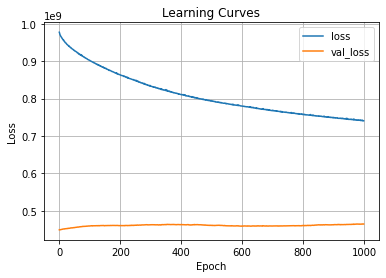

In [ ]:
def plot_losses(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Learning Curves")
  plt.legend()
  plt.grid(True)

plot_losses(model_histories[simple_handle])

In [ ]:
model_evaluations[simple_handle] = models[simple_handle].evaluate(X_valid_imputed, y_valid)
print(model_evaluations[simple_handle])

14/14 [==============================] - 0s 1ms/step - loss: 1424932480.0000
1424932480.0


In [ ]:
X_test_imputed = pd.DataFrame(impute.transform(X_test[numerical_cols]), columns=numerical_cols)
X_test_imputed

,OverallQual,WoodDeckSF,Fireplaces,MiscVal,GrLivArea,LotFrontage,PoolArea,EnclosedPorch,3SsnPorch,1stFlrSF,2ndFlrSF,TotalBsmtSF,MasVnrArea,BsmtFullBath,LotArea,BsmtUnfSF,GarageYrBlt,OpenPorchSF,BsmtFinSF1,BedroomAbvGr,HalfBath,LowQualFinSF,KitchenAbvGr,OverallCond,MoSold,BsmtFinSF2,YearRemodAdd,YearBuilt,TotRmsAbvGrd,BsmtHalfBath,GarageCars,ScreenPorch,GarageArea,FullBath,YrSold
0,5.0,140.0,0.0,0.0,896.0,80.0,0.0,0.0,0.0,896.0,0.0,882.0,0.0,0.0,11622.0,270.0,1961.000000,0.0,468.0,2.0,0.0,0.0,1.0,6.0,6.0,144.0,1961.0,1961.0,5.0,0.0,1.0,120.0,730.0,1.0,2010.0
1,6.0,393.0,0.0,12500.0,1329.0,81.0,0.0,0.0,0.0,1329.0,0.0,1329.0,108.0,0.0,14267.0,406.0,1958.000000,36.0,923.0,3.0,1.0,0.0,1.0,6.0,6.0,0.0,1958.0,1958.0,6.0,0.0,1.0,0.0,312.0,1.0,2010.0
2,5.0,212.0,1.0,0.0,1629.0,74.0,0.0,0.0,0.0,928.0,701.0,928.0,0.0,0.0,13830.0,137.0,1997.000000,34.0,791.0,3.0,1.0,0.0,1.0,5.0,3.0,0.0,1998.0,1997.0,6.0,0.0,2.0,0.0,482.0,2.0,2010.0
3,6.0,360.0,1.0,0.0,1604.0,78.0,0.0,0.0,0.0,926.0,678.0,926.0,20.0,0.0,9978.0,324.0,1998.000000,36.0,602.0,3.0,1.0,0.0,1.0,6.0,6.0,0.0,1998.0,1998.0,7.0,0.0,2.0,0.0,470.0,2.0,2010.0
4,8.0,0.0,0.0,0.0,1280.0,43.0,0.0,0.0,0.0,1280.0,0.0,1280.0,0.0,0.0,5005.0,1017.0,1992.000000,82.0,263.0,2.0,0.0,0.0,1.0,5.0,1.0,0.0,1992.0,1992.0,5.0,0.0,2.0,144.0,506.0,2.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,0.0,0.0,0.0,1092.0,21.0,0.0,0.0,0.0,546.0,546.0,546.0,0.0,0.0,1936.0,546.0,1978.012397,0.0,0.0,3.0,1.0,0.0,1.0,7.0,6.0,0.0,1970.0,1970.0,5.0,0.0,0.0,0.0,0.0,1.0,2006.0
1455,4.0,0.0,0.0,0.0,1092.0,21.0,0.0,0.0,0.0,546.0,546.0,546.0,0.0,0.0,1894.0,294.0,1970.000000,24.0,252.0,3.0,1.0,0.0,1.0,5.0,4.0,0.0,1970.0,1970.0,6.0,0.0,1.0,0.0,286.0,1.0,2006.0
1456,5.0,474.0,1.0,0.0,1224.0,160.0,0.0,0.0,0.0,1224.0,0.0,1224.0,0.0,1.0,20000.0,0.0,1960.000000,0.0,1224.0,4.0,0.0,0.0,1.0,7.0,9.0,0.0,1996.0,1960.0,7.0,0.0,2.0,0.0,576.0,1.0,2006.0
1457,5.0,80.0,0.0,700.0,970.0,62.0,0.0,0.0,0.0,970.0,0.0,912.0,0.0,0.0,10441.0,575.0,1978.012397,32.0,337.0,3.0,0.0,0.0,1.0,5.0,7.0,0.0,1992.0,1992.0,6.0,1.0,0.0,0.0,0.0,1.0,2006.0


In [ ]:
y_preds = models[simple_handle].predict(X_test_imputed)
y_preds.flatten()

array([127900.484, 155758.7  , 172525.45 , ..., 195817.52 , 103353.84 ,
       241812.17 ], dtype=float32)

In [ ]:
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': y_preds.flatten() })
output.to_csv(workdir + '/ann-submission1.csv', index=False)